# 現実写真以外を含む、文字なし、固有名詞全部なし、キャプション、ほかの画像の大喜利

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
EXPERIENCE_NUMBER = "002"
    
USE_UNREAL_IMAGE = True
USE_WORD_IMAGE = False
USE_UNIQUE_NOUN_BOKE = False
USE_CAPTION = True
USE_MISS_BOKE = True

EPOCH = 25
BATCH_SIZE = 256

RESULT_DIR = f"../../results/Boke_Judge/{EXPERIENCE_NUMBER}/"
if not os.path.exists("../../results/Boke_Judge/"):
    os.mkdir("../../results/Boke_Judge/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

DATA_DIR = "../../datas/boke_data_assemble/"
CLIP_IMAGE_FEATURE_DIR = "../../datas/encoded/clip_image_feature/"
CLIP_SENTENCE_FEATURE_DIR = "../../datas/encoded/clip_sentence_feature/"
LUKE_SENTENCE_FEATURE_DIR = "../../datas/encoded/luke_sentence_feature/"

# データセットの作成(初回のみ実行)

In [3]:
boke_datas = list()
caption_datas = list()

max_num_boke = 0
for JP in tqdm(os.listdir(DATA_DIR)):
    N = int(JP.split(".")[0])

    with open(f"{DATA_DIR}{JP}", "r") as f:
        a = json.load(f)

    image_information = a["image_infomation"]
    is_photographic_probability = image_information["is_photographic_probability"]
    ja_caption = image_information["ja_caption"]
    ocr = image_information["ocr"]

    # 現実写真以外を除去
    if not USE_UNREAL_IMAGE:
        if is_photographic_probability < 0.8: continue
        
    # 文字のある画像を除去
    if not USE_WORD_IMAGE:
        if len(ocr) != 0: continue

    bokes = a["bokes"]

    max_num_boke = max(max_num_boke, len(a["bokes"]))
    for i, B in enumerate(bokes):

        # 固有名詞を含む大喜利を除去
        if not USE_UNIQUE_NOUN_BOKE:
            if len(B["unique_nouns"]) != 0: continue

        boke_datas.append({
            "boke_number": int(f"1{N:07}{i:05}"),
            "image_number": int(f"3{N:07}")
        })

    caption_datas.append({
        "caption_number": int(f"2{N:07}"),
        "image_number": int(f"3{N:07}")
    })

len(boke_datas), len(caption_datas)

100%|██████████| 602566/602566 [03:11<00:00, 3146.93it/s]


(2811389, 289837)

In [4]:
train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)
train_caption_datas, test_caption_datas = train_test_split(caption_datas, test_size = 0.01)

with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
    json.dump(train_boke_datas, f)
with open(f"{RESULT_DIR}train_caption_datas.json", "w") as f:
    json.dump(train_caption_datas, f)

with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
    json.dump(test_boke_datas, f)
with open(f"{RESULT_DIR}test_caption_datas.json", "w") as f:
    json.dump(test_caption_datas, f)

# モデルの学習

In [5]:
with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
    train_boke_datas = json.load(f)
with open(f"{RESULT_DIR}train_caption_datas.json", "r") as f:
    train_caption_datas = json.load(f)

with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
    test_boke_datas = json.load(f)
with open(f"{RESULT_DIR}test_caption_datas.json", "r") as f:
    test_caption_datas = json.load(f)

len(train_boke_datas), len(train_caption_datas), len(test_boke_datas), len(test_caption_datas)

(2783275, 286938, 28114, 2899)

In [6]:
def make_dataloader(boke_datas, caption_datas):
    class LoadNpyDataset(Dataset):
        def __init__(self, image_file_numbers, sentence_file_numbers, teacher_signals):
            if len(image_file_numbers) != len(sentence_file_numbers) and len(sentence_file_numbers) != len(teacher_signals):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_numbers = image_file_numbers
            self.sentence_file_numbers = sentence_file_numbers
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            clip_image_feature = np.load(f"{CLIP_IMAGE_FEATURE_DIR}{self.image_file_numbers[idx]}.npy")
            clip_sentence_feature = np.load(f"{CLIP_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            luke_sentence_feature = np.load(f"{LUKE_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            teacher_signal = self.teacher_signals[idx]

            return clip_image_feature, clip_sentence_feature, luke_sentence_feature, teacher_signal

    def collate_fn_tf(batch):
        clip_image_features = np.array([B[0] for B in batch])
        clip_sentence_features = np.array([B[1] for B in batch])
        luke_sentence_features = np.array([B[2] for B in batch])
        teacher_signals = np.array([float(B[3]) for B in batch])
        
        return clip_image_features, clip_sentence_features, luke_sentence_features, teacher_signals

    #
    image_file_numbers = list()
    sentence_file_numbers = list()
    teacher_signals = list()

    for D in boke_datas:
        image_file_numbers.append(D["image_number"])
        sentence_file_numbers.append(D["boke_number"])
        teacher_signals.append(1)

    if USE_CAPTION:
        for D in caption_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["caption_number"])
            teacher_signals.append(0)
    
    if USE_MISS_BOKE:
        miss_boke_datas = list()
        tmp_idx = np.random.randint(0, len(boke_datas), size = (len(boke_datas), ))
        for i, idx in tqdm(enumerate(tmp_idx)):
            tmp_boke_number = boke_datas[idx]["boke_number"]
            while str(tmp_boke_number)[:7] == str(boke_datas[i]["boke_number"])[:7]:
                idx = np.random.randint(0, len(boke_datas))
                tmp_boke_number = boke_datas[idx]["boke_number"]

            miss_boke_datas.append({
                "boke_number": tmp_boke_number,
                "image_number": boke_datas[i]["image_number"]
            })
        
        for D in miss_boke_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["boke_number"])
            teacher_signals.append(0)
    
    print(f"num data: {len(teacher_signals)}")

    tmp = list(zip(image_file_numbers, sentence_file_numbers, teacher_signals))
    np.random.shuffle(tmp)
    image_file_numbers, sentence_file_numbers, teacher_signals = zip(*tmp)

    dataset = LoadNpyDataset(image_file_numbers, sentence_file_numbers, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = 10, 
        collate_fn = collate_fn_tf
    )

    return dataloader

train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)

#
CIF, CSF, LSF, TS = next(iter(train_dataloader))
CIF.shape, CSF.shape, LSF.shape, TS.shape

2783275it [00:02, 1126053.29it/s]


num data: 5853488


28114it [00:00, 88412.56it/s]

num data: 59127


((256, 512), (256, 512), (256, 768), (256,))

In [7]:
class CustomModel(nn.Module):
    def __init__(self, cif_dim, csf_dim, lsf_dim):
        super(CustomModel, self).__init__()
        # 入力次元を設定
        self.cif_dim = cif_dim
        self.csf_dim = csf_dim
        self.lsf_dim = lsf_dim
        
        # 全結合層
        self.fc1 = nn.Linear(cif_dim + csf_dim + lsf_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 1)
        
    def forward(self, cif, csf, lsf):
        # 入力を結合
        x = torch.cat([cif, csf, lsf], dim=1)
        # 全結合層 + LeakyReLU
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # 出力層 + シグモイド
        output = torch.sigmoid(self.output_layer(x))
        return output

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
print(model)

CustomModel(
  (fc1): Linear(in_features=1792, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
)


In [8]:
def train_step(model, optimizer, batch_data, batch_labels):
    model.train()  # モデルを訓練モードに設定
    optimizer.zero_grad()  # 勾配を初期化
    outputs = model(*batch_data).float()  # モデルで予測を計算
    loss = nn.BCELoss()(outputs, batch_labels.float())  # 損失関数（バイナリクロスエントロピー）
    accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()  # 精度計算
    loss.backward()  # 勾配を計算
    optimizer.step()  # パラメータ更新
    return loss.item(), accuracy.item()

def evaluate(model, batch_data, batch_labels):
    model.eval()  # モデルを評価モードに設定
    with torch.no_grad():  # 評価時に勾配計算を行わない
        outputs = model(*batch_data)
        loss = nn.BCELoss()(outputs, batch_labels)
        accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()
    return loss.item(), accuracy.item()

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)

# 訓練・評価ループ
for epoch in range(EPOCH):
    # 訓練
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()  # 訓練モード
    train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH}")
    
    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF), torch.tensor(CSF), torch.tensor(LSF), torch.tensor(TS)
        batch_data = (CIF, CSF, LSF)  # 入力データ
        batch_labels = TS.unsqueeze(1)  # 出力ラベル（shape: [batch_size, 1]）
        
        loss, accuracy = train_step(model, optimizer, batch_data, batch_labels)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})

    # 訓練後の損失と精度
    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # テスト
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()  # 評価モード
    test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF).float(), torch.tensor(CSF).float(), torch.tensor(LSF).float(), torch.tensor(TS).float()
        batch_data = (CIF, CSF, LSF)
        batch_labels = TS.unsqueeze(1).float()
        
        loss, accuracy = evaluate(model, batch_data, batch_labels)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})

    # テスト後の損失と精度
    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    # 結果表示
    print(f"Epoch: {epoch+1}/{EPOCH}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # 履歴の保存
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

# 結果をJSONファイルに保存
with open(f"{RESULT_DIR}history.json", "w") as f:
    json.dump({
        "train_loss": train_loss_history,
        "train_accuracy": train_accuracy_history,
        "test_loss": test_loss_history,
        "test_accuracy": test_accuracy_history
    }, f)


2783275it [00:02, 1127710.74it/s]


num data: 5853488


Epoch 1/25: 100%|██████████| 22866/22866 [10:38<00:00, 35.83it/s, train_loss=0.595, train_accuracy=0.659]
28114it [00:00, 1297520.50it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 58.79it/s, test_loss=0.574, test_accuracy=0.699] 


Epoch: 1/25, Train Loss: 0.5950, Train Accuracy: 0.6585, Test Loss: 0.5664, Test Accuracy: 0.6903


2783275it [00:02, 1123697.53it/s]


num data: 5853488


Epoch 2/25: 100%|██████████| 22866/22866 [09:04<00:00, 41.98it/s, train_loss=0.56, train_accuracy=0.695] 
28114it [00:00, 1174091.07it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 57.85it/s, test_loss=0.559, test_accuracy=0.712] 


Epoch: 2/25, Train Loss: 0.5598, Train Accuracy: 0.6952, Test Loss: 0.5516, Test Accuracy: 0.7030


2783275it [00:02, 1120864.19it/s]


num data: 5853488


Epoch 3/25: 100%|██████████| 22866/22866 [10:41<00:00, 35.66it/s, train_loss=0.544, train_accuracy=0.709]
28114it [00:00, 1093023.58it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 46.65it/s, test_loss=0.565, test_accuracy=0.735]


Epoch: 3/25, Train Loss: 0.5435, Train Accuracy: 0.7093, Test Loss: 0.5453, Test Accuracy: 0.7099


2783275it [00:02, 1145031.46it/s]


num data: 5853488


Epoch 4/25: 100%|██████████| 22866/22866 [08:58<00:00, 42.43it/s, train_loss=0.531, train_accuracy=0.719]
28114it [00:00, 1359151.93it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 59.23it/s, test_loss=0.54, test_accuracy=0.722]  


Epoch: 4/25, Train Loss: 0.5310, Train Accuracy: 0.7194, Test Loss: 0.5352, Test Accuracy: 0.7154


2783275it [00:02, 1151013.53it/s]


num data: 5853488


Epoch 5/25: 100%|██████████| 22866/22866 [10:07<00:00, 37.61it/s, train_loss=0.521, train_accuracy=0.727]
28114it [00:00, 1298635.08it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 57.10it/s, test_loss=0.545, test_accuracy=0.741]


Epoch: 5/25, Train Loss: 0.5208, Train Accuracy: 0.7274, Test Loss: 0.5305, Test Accuracy: 0.7213


2783275it [00:02, 1130996.49it/s]


num data: 5853488


Epoch 6/25: 100%|██████████| 22866/22866 [09:08<00:00, 41.72it/s, train_loss=0.512, train_accuracy=0.734]
28114it [00:00, 1324006.45it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 58.60it/s, test_loss=0.548, test_accuracy=0.755]


Epoch: 6/25, Train Loss: 0.5116, Train Accuracy: 0.7343, Test Loss: 0.5264, Test Accuracy: 0.7254


2783275it [00:02, 1142052.90it/s]


num data: 5853488


Epoch 7/25: 100%|██████████| 22866/22866 [11:33<00:00, 32.97it/s, train_loss=0.503, train_accuracy=0.74]  
28114it [00:00, 1308274.02it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 58.55it/s, test_loss=0.557, test_accuracy=0.765] 


Epoch: 7/25, Train Loss: 0.5033, Train Accuracy: 0.7403, Test Loss: 0.5277, Test Accuracy: 0.7252


2783275it [00:02, 1123221.70it/s]


num data: 5853488


Epoch 8/25: 100%|██████████| 22866/22866 [13:38<00:00, 27.95it/s, train_loss=0.496, train_accuracy=0.745] 
28114it [00:00, 1398748.12it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 59.66it/s, test_loss=0.53, test_accuracy=0.729]  


Epoch: 8/25, Train Loss: 0.4959, Train Accuracy: 0.7454, Test Loss: 0.5273, Test Accuracy: 0.7256


2783275it [00:02, 1119300.41it/s]


num data: 5853488


Epoch 9/25: 100%|██████████| 22866/22866 [13:13<00:00, 28.80it/s, train_loss=0.489, train_accuracy=0.751]
28114it [00:00, 1372887.30it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 57.25it/s, test_loss=0.548, test_accuracy=0.749]


Epoch: 9/25, Train Loss: 0.4886, Train Accuracy: 0.7504, Test Loss: 0.5318, Test Accuracy: 0.7268


2783275it [00:02, 1145912.42it/s]


num data: 5853488


Epoch 10/25: 100%|██████████| 22866/22866 [12:47<00:00, 29.80it/s, train_loss=0.482, train_accuracy=0.755]
28114it [00:00, 1309000.17it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 59.87it/s, test_loss=0.525, test_accuracy=0.731] 


Epoch: 10/25, Train Loss: 0.4820, Train Accuracy: 0.7547, Test Loss: 0.5253, Test Accuracy: 0.7313


2783275it [00:02, 1132435.60it/s]


num data: 5853488


Epoch 11/25: 100%|██████████| 22866/22866 [13:40<00:00, 27.86it/s, train_loss=0.476, train_accuracy=0.759]
28114it [00:00, 1331361.21it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 60.19it/s, test_loss=0.532, test_accuracy=0.733] 


Epoch: 11/25, Train Loss: 0.4758, Train Accuracy: 0.7586, Test Loss: 0.5298, Test Accuracy: 0.7294


2783275it [00:02, 1127197.55it/s]


num data: 5853488


Epoch 12/25: 100%|██████████| 22866/22866 [13:56<00:00, 27.33it/s, train_loss=0.469, train_accuracy=0.763] 
28114it [00:00, 1363489.50it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 59.76it/s, test_loss=0.538, test_accuracy=0.73]  


Epoch: 12/25, Train Loss: 0.4695, Train Accuracy: 0.7628, Test Loss: 0.5361, Test Accuracy: 0.7269


2783275it [00:02, 1148519.96it/s]


num data: 5853488


Epoch 13/25: 100%|██████████| 22866/22866 [13:58<00:00, 27.28it/s, train_loss=0.464, train_accuracy=0.766]
28114it [00:00, 1404596.23it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 55.93it/s, test_loss=0.556, test_accuracy=0.757]


Epoch: 13/25, Train Loss: 0.4638, Train Accuracy: 0.7663, Test Loss: 0.5367, Test Accuracy: 0.7304


2783275it [00:02, 1140608.32it/s]


num data: 5853488


Epoch 14/25: 100%|██████████| 22866/22866 [13:50<00:00, 27.53it/s, train_loss=0.458, train_accuracy=0.77]  
28114it [00:00, 1340457.01it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 60.38it/s, test_loss=0.545, test_accuracy=0.733] 


Epoch: 14/25, Train Loss: 0.4579, Train Accuracy: 0.7699, Test Loss: 0.5426, Test Accuracy: 0.7299


2783275it [00:02, 1147598.55it/s]


num data: 5853488


Epoch 15/25: 100%|██████████| 22866/22866 [13:46<00:00, 27.66it/s, train_loss=0.453, train_accuracy=0.773] 
28114it [00:00, 1337052.40it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 58.37it/s, test_loss=0.559, test_accuracy=0.756]


Epoch: 15/25, Train Loss: 0.4529, Train Accuracy: 0.7732, Test Loss: 0.5401, Test Accuracy: 0.7302


2783275it [00:02, 1143934.68it/s]


num data: 5853488


Epoch 16/25: 100%|██████████| 22866/22866 [14:33<00:00, 26.19it/s, train_loss=0.447, train_accuracy=0.777]
28114it [00:00, 1184445.56it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 57.22it/s, test_loss=0.572, test_accuracy=0.768] 


Epoch: 16/25, Train Loss: 0.4474, Train Accuracy: 0.7766, Test Loss: 0.5445, Test Accuracy: 0.7315


2783275it [00:02, 1142348.61it/s]


num data: 5853488


Epoch 17/25: 100%|██████████| 22866/22866 [13:38<00:00, 27.94it/s, train_loss=0.443, train_accuracy=0.779] 
28114it [00:00, 1339360.78it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 57.39it/s, test_loss=0.546, test_accuracy=0.729] 


Epoch: 17/25, Train Loss: 0.4430, Train Accuracy: 0.7794, Test Loss: 0.5462, Test Accuracy: 0.7293


2783275it [00:02, 1134232.78it/s]


num data: 5853488


Epoch 18/25: 100%|██████████| 22866/22866 [12:45<00:00, 29.87it/s, train_loss=0.438, train_accuracy=0.782]
28114it [00:00, 1323219.02it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 58.18it/s, test_loss=0.563, test_accuracy=0.732] 


Epoch: 18/25, Train Loss: 0.4383, Train Accuracy: 0.7824, Test Loss: 0.5606, Test Accuracy: 0.7291


2783275it [00:02, 1133171.32it/s]


num data: 5853488


Epoch 19/25: 100%|██████████| 22866/22866 [13:59<00:00, 27.24it/s, train_loss=0.434, train_accuracy=0.785]
28114it [00:00, 1379004.36it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 57.19it/s, test_loss=0.591, test_accuracy=0.758]


Epoch: 19/25, Train Loss: 0.4340, Train Accuracy: 0.7849, Test Loss: 0.5679, Test Accuracy: 0.7286


2783275it [00:02, 1146138.90it/s]


num data: 5853488


Epoch 20/25: 100%|██████████| 22866/22866 [13:54<00:00, 27.40it/s, train_loss=0.43, train_accuracy=0.788]  
28114it [00:00, 1388830.61it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 57.49it/s, test_loss=0.58, test_accuracy=0.738] 


Epoch: 20/25, Train Loss: 0.4295, Train Accuracy: 0.7879, Test Loss: 0.5728, Test Accuracy: 0.7283


2783275it [00:02, 1162030.74it/s]


num data: 5853488


Epoch 21/25: 100%|██████████| 22866/22866 [12:59<00:00, 29.33it/s, train_loss=0.426, train_accuracy=0.79] 
28114it [00:00, 1318602.47it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:03<00:00, 58.82it/s, test_loss=0.593, test_accuracy=0.749] 


Epoch: 21/25, Train Loss: 0.4258, Train Accuracy: 0.7901, Test Loss: 0.5779, Test Accuracy: 0.7291


2783275it [00:02, 1130743.21it/s]


num data: 5853488


Epoch 22/25: 100%|██████████| 22866/22866 [13:10<00:00, 28.93it/s, train_loss=0.422, train_accuracy=0.793] 
28114it [00:00, 1005737.19it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:24<00:00,  9.45it/s, test_loss=0.604, test_accuracy=0.756]


Epoch: 22/25, Train Loss: 0.4221, Train Accuracy: 0.7925, Test Loss: 0.5805, Test Accuracy: 0.7264


2783275it [00:02, 1205404.76it/s]


num data: 5853488


Epoch 23/25: 100%|██████████| 22866/22866 [12:50<00:00, 29.68it/s, train_loss=0.419, train_accuracy=0.795]
28114it [00:00, 1383421.08it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 56.72it/s, test_loss=0.608, test_accuracy=0.756]


Epoch: 23/25, Train Loss: 0.4187, Train Accuracy: 0.7946, Test Loss: 0.5873, Test Accuracy: 0.7297


2783275it [00:02, 1162313.63it/s]


num data: 5853488


Epoch 24/25: 100%|██████████| 22866/22866 [13:38<00:00, 27.94it/s, train_loss=0.415, train_accuracy=0.797]
28114it [00:00, 1290138.54it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:04<00:00, 56.44it/s, test_loss=0.627, test_accuracy=0.767] 


Epoch: 24/25, Train Loss: 0.4147, Train Accuracy: 0.7972, Test Loss: 0.5941, Test Accuracy: 0.7269


2783275it [00:02, 1117413.07it/s]


num data: 5853488


Epoch 25/25: 100%|██████████| 22866/22866 [13:47<00:00, 27.65it/s, train_loss=0.412, train_accuracy=0.799]
28114it [00:00, 1275154.77it/s]


num data: 59127


Evaluating: 100%|██████████| 231/231 [00:05<00:00, 41.91it/s, test_loss=0.608, test_accuracy=0.738]

Epoch: 25/25, Train Loss: 0.4118, Train Accuracy: 0.7994, Test Loss: 0.6001, Test Accuracy: 0.7283


In [ ]:
torch.save(model.state_dict(), f"{RESULT_DIR}model_weights.pth")

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
model.load_state_dict(torch.load(f"{RESULT_DIR}model_weights.pth",
                                 map_location=torch.device('cpu')))
model.eval()

<ipython-input-12-a858965dba87>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{RESULT_DIR}model_weights.pth",


CustomModel(
  (fc1): Linear(in_features=1792, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
)

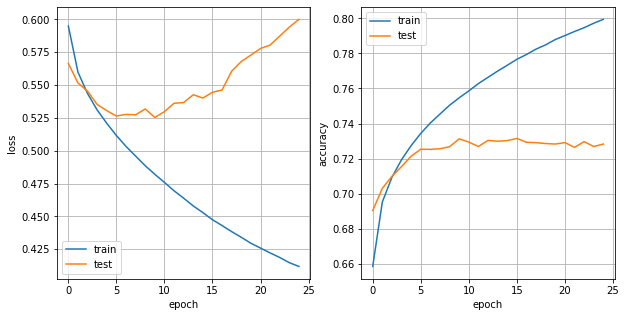

In [10]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()